# Cell Type Prediction

There are different ways to predict cell types, e. g. using astir or argmax. Here, we demonstrate how to filter data and then use argmax to get a quick initial prediction.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatialproteomics
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('../../data/BNHL_166_4_I2_LK.zarr')
ds["_properties"] = ds["_labels"]
ds = ds.pp.drop_layers("_labels")

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# preprocessing: filtering by percentiles and applying a median filter
channels = ['PAX5', 'CD3', 'CD11b', 'CD11c', 'CD15', 'CD68', 'Podoplanin', 'CD31', 'CD34', 'CD90', 'CD56', 'CD4', 'CD8']
quantiles = [0.8, 0.5, 0.8, 0.8, 0.8, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8, 0.8, 0.8]
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#ffd8b1', '#f58231', '#911eb4', '#fffac8', '#469990', '#fabed4', '#9A6324', '#3cb44b', '#3cb44b']

channels_celltypes = channels[:-2]
colors_celltypes = colors[:-2]

ds_processed = ds.pp[channels].pp.filter(quantiles).pp.restore('medfilt2d', kernel_size=3)

/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatialproteomics/spatialproteomics/pl/plot.py:21: AccessorRegistrationWarning: registration of accessor <class 'spatialproteomics.pl.plot.PlotAccessor'> under name 'pl' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class PlotAccessor:


Text(0.5, 1.0, 'Processed')

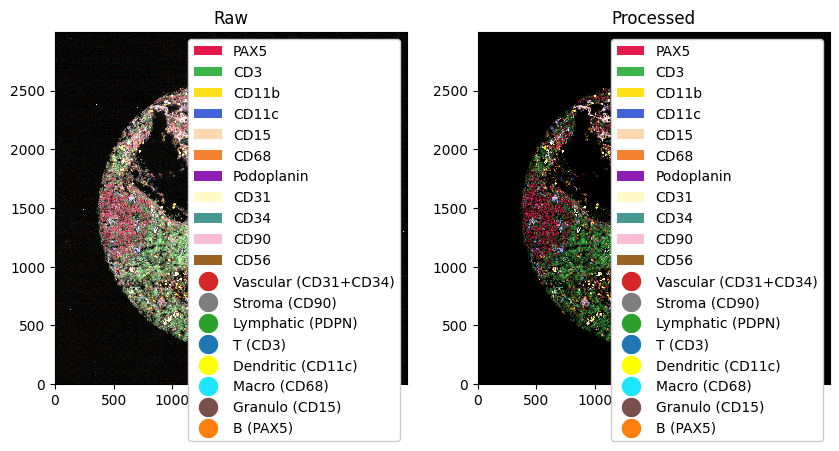

In [8]:
# plotting the ds and ds processed next to one another

# visualizing the raw vs the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[0])
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[1])

ax[0].set_title("Raw")
ax[1].set_title("Processed")

In [9]:
ct_marker_dict = {'B': 'PAX5', 'T': 'CD3', 'Myeloid': 'CD11b', 'Dendritic': 'CD11c', 'Granulo': 'CD15', 'Macro': 'CD68', 'Stroma PDPN': 'Podoplanin', 'Stroma CD31': 'CD31', 'Stroma CD34': 'CD34', 'Stroma CD90': 'CD90', 'NK': 'CD56'}

In [10]:
# predicting the cell type using the argmay
ds_with_ct_predictions = ds_processed.la.predict_cell_types_argmax(ct_marker_dict, key='_arcsinh_mean', overwrite_existing_labels=True)

# adding colors to match the markers
ds_with_ct_predictions = ds_with_ct_predictions.la.set_label_colors(list(ct_marker_dict.keys()), colors_celltypes)

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
Label Stroma PDPN not found in the data object. Skipping.
Label Stroma CD31 not found in the data object. Skipping.


Text(0.5, 1.0, 'Cell Type Predictions')

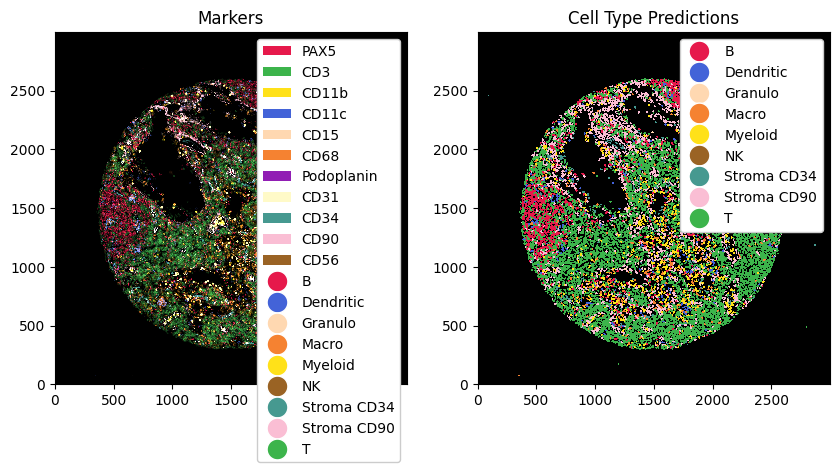

In [12]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds_with_ct_predictions.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.show(ax=ax[0])
_ = ds_with_ct_predictions.pl.show(render_image=False, render_labels=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

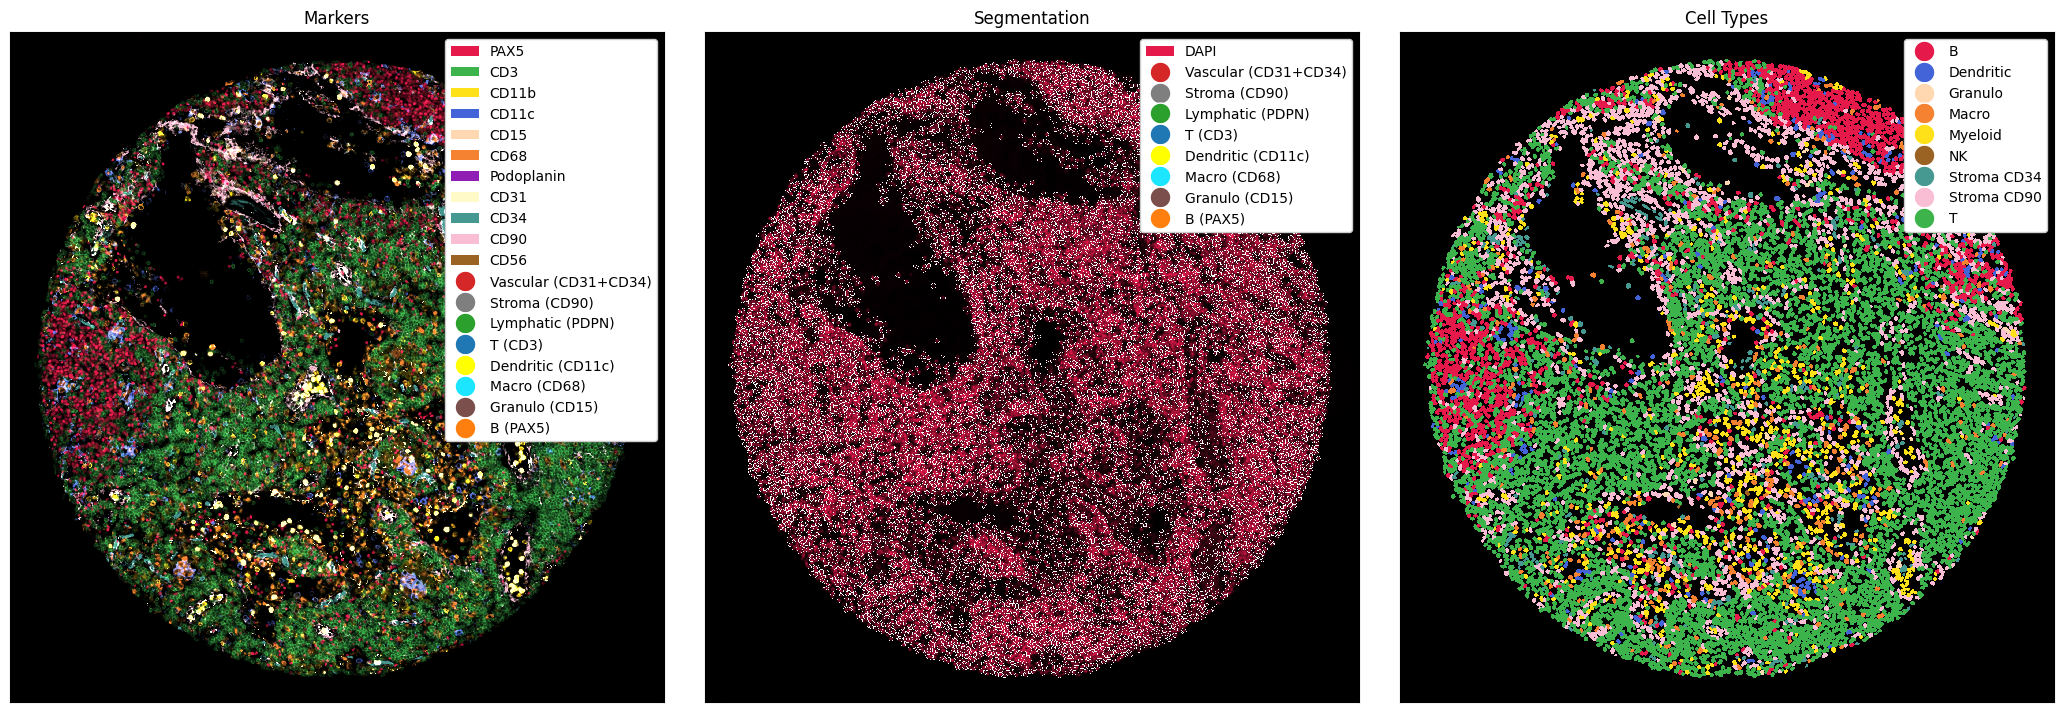

In [13]:
# this is how the image in the README was created
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
_ = ds_processed.pp[channels_celltypes].pl.colorize(colors_celltypes).pl.autocrop(padding=100).pl.show(ax=ax[0])
_ = ds.pp['DAPI'].pl.autocrop(padding=100).pl.show(render_segmentation=True, ax=ax[1])
_ = ds_with_ct_predictions.pl.autocrop(padding=100).pl.show(render_image=False, render_labels=True, ax=ax[2])


# removing the x and y ticks
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

# setting titles
ax[0].set_title('Markers')
ax[1].set_title('Segmentation')
ax[2].set_title('Cell Types')

plt.tight_layout()

Getting observations from the xarray object is very easy. However, since the cell types are stored as integers, the method `la.get_obs(celltypes_to_str=True)` allows you to export the obs in a more readable format.

In [14]:
# getting the obs table directly from the xarray object
ds_with_ct_predictions['_obs']

<xarray.DataArray '_obs' (cells: 12560, features: 4)>
array([[9.00000000e+00, 3.00000000e+00, 6.13329787e+02, 7.68420213e+02],
       [4.00000000e+00, 5.00000000e+00, 7.69098446e+02, 7.07544041e+02],
       [9.00000000e+00, 2.00000000e+00, 7.74528409e+02, 6.44284091e+02],
       ...,
       [9.00000000e+00, 2.00000000e+00, 2.26591085e+03, 2.23199225e+03],
       [1.00000000e+00, 7.00000000e+00, 2.28148069e+03, 2.21842489e+03],
       [1.00000000e+00, 7.00000000e+00, 2.24906944e+03, 2.23656481e+03]])
Coordinates:
  * cells     (cells) int64 1 2 3 4 5 6 ... 12555 12556 12557 12558 12559 12560
  * features  (features) <U10 '_labels' '_original_' 'centroid-0' 'centroid-1'

In [15]:
# getting the obs with get_layer_as_df() to get human readable cell type annotations in a pandas data frame
ds_with_ct_predictions.pp.get_layer_as_df('_obs')

_labels  _original_   centroid-0   centroid-1
1                T         3.0   613.329787   768.420213
2            Macro         5.0   769.098446   707.544041
3                T         2.0   774.528409   644.284091
4                T         3.0   775.902878   592.744604
5          Myeloid         5.0   668.844749   729.310502
...            ...         ...          ...          ...
12556            B         7.0  2340.362319  1846.492754
12557  Stroma CD90         5.0  2216.324138  2296.089655
12558            T         2.0  2265.910853  2231.992248
12559            B         7.0  2281.480687  2218.424893
12560            B         7.0  2249.069444  2236.564815

[12560 rows x 4 columns]

# Marker Binarization

For some (functional) markers, we want to binarize them (i. e. is a cell positive or negative for that marker). This can be achieved with the `la.add_binarization` function.

In [16]:
# these thresholds are the percentages of positive cells required
threshold_dict = {
    "PAX5": 0.9,
    "CD3": 0.9,
    "CD4": 0.95,
    "CD8": 0.95,
}

ds_with_binarization = ds_with_ct_predictions.la.add_binarization(threshold_dict)

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/meye

Text(0.5, 1.0, 'CD8 binarization')

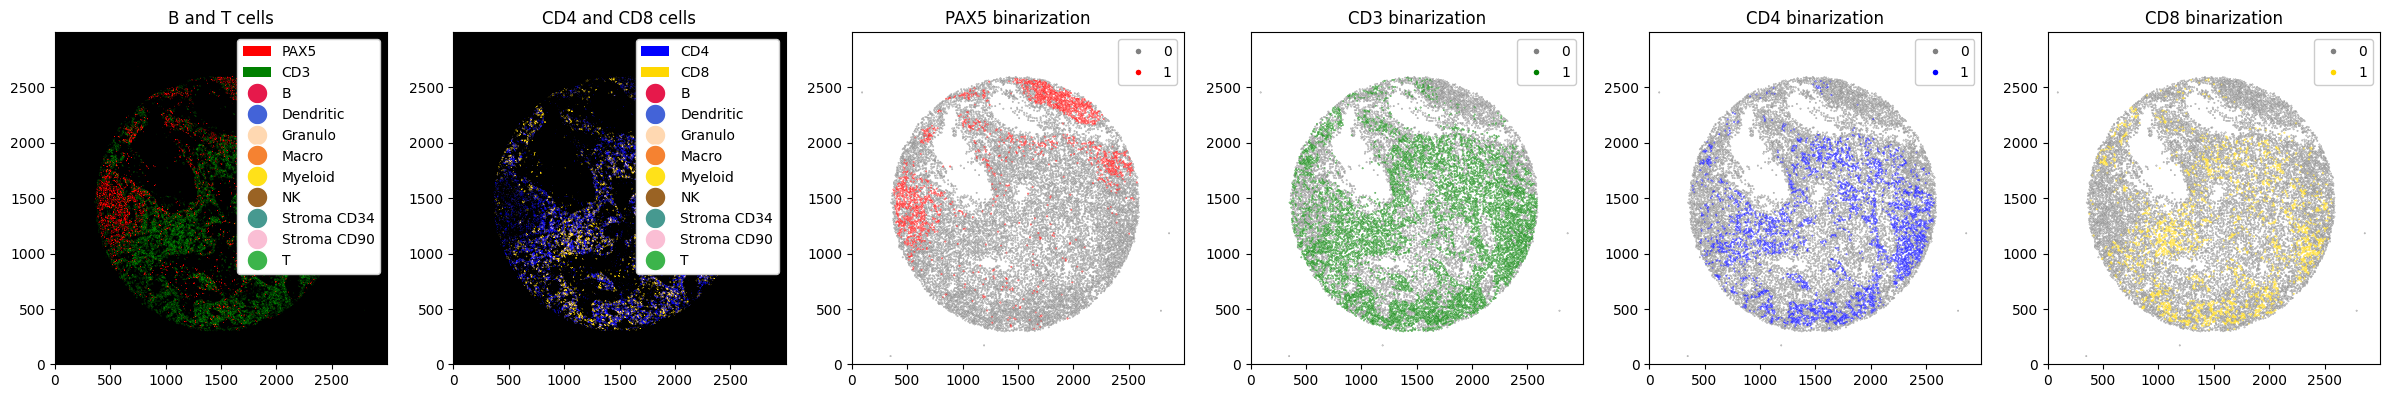

In [17]:
# plotting the binarization next to the marker intensities
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

_ = ds_with_binarization.pp[['PAX5', 'CD3']].pl.colorize(['red', 'green']).pl.show(render_image=True, render_labels=False, ax=ax[0])
_ = ds_with_binarization.pp[['CD4', 'CD8']].pl.colorize(['blue', 'gold']).pl.show(render_image=True, render_labels=False, ax=ax[1])

_ = ds_with_binarization.pl.scatter(feature='PAX5_binarized', size=0.1, palette={0: 'gray', 1: 'red'}, ax=ax[2])
_ = ds_with_binarization.pl.scatter(feature='CD3_binarized', size=0.1, palette={0: 'gray', 1: 'green'}, ax=ax[3])
_ = ds_with_binarization.pl.scatter(feature='CD4_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[4])
_ = ds_with_binarization.pl.scatter(feature='CD8_binarized', size=0.1, palette={0: 'gray', 1: 'gold'}, ax=ax[5])

ax[0].set_title("B and T cells")
ax[1].set_title("CD4 and CD8 cells")
ax[2].set_title("PAX5 binarization")
ax[3].set_title("CD3 binarization")
ax[4].set_title("CD4 binarization")
ax[5].set_title("CD8 binarization")

We can also just subset from a single cell type. For example, consider a low CD4 threshold, once on all cells and once on only the T cells. For illustrative purposes, we have only applied a relaxed filter (80-percentile) to CD4 previously. We also choose a very relaxed threshold here, just to show the concept of subsetting when binarizing a marker.

In [18]:
threshold_dict = {
    "CD4": 0.5
}

# in the first one, we binarize CD4 on all cells
ds_with_binarization_cd4 = ds_with_ct_predictions.la.add_binarization(threshold_dict)
# in the second one, we only look at CD4 in the T cells
ds_with_binarization_cd4_t = ds_with_ct_predictions.la.add_binarization(threshold_dict, cell_type='T')

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Text(0.5, 1.0, 'CD4 on T cells only')

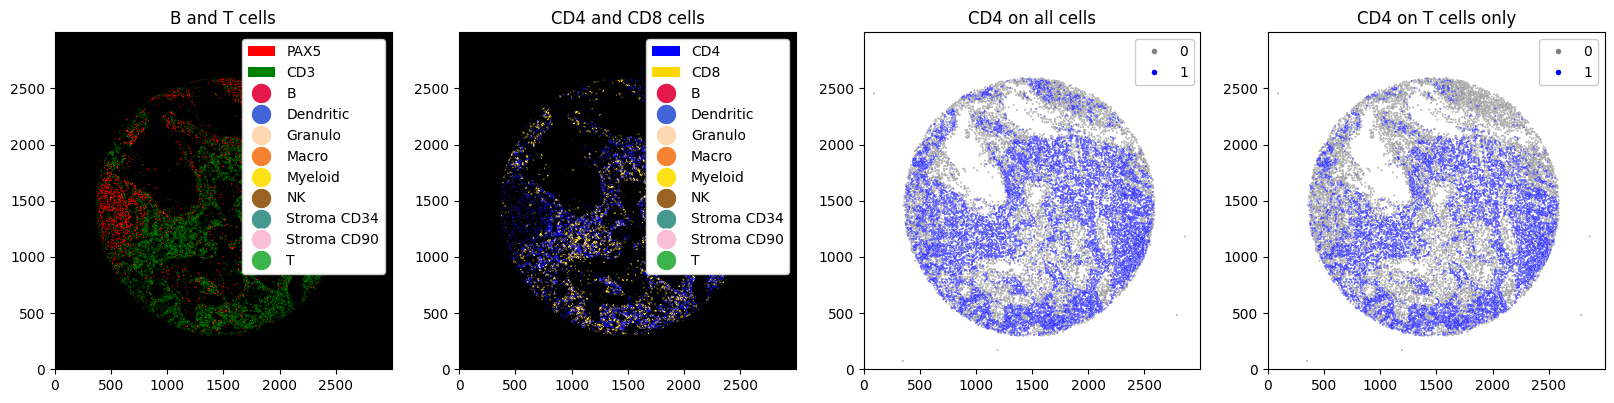

In [20]:
# plotting the binarization next to the marker intensities
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

_ = ds_with_binarization_cd4.pp[['PAX5', 'CD3']].pl.colorize(['red', 'green']).pl.show(render_image=True, render_labels=False, ax=ax[0])
_ = ds_with_binarization_cd4.pp[['CD4', 'CD8']].pl.colorize(['blue', 'gold']).pl.show(render_image=True, render_labels=False, ax=ax[1])

_ = ds_with_binarization_cd4.pl.scatter(feature='CD4_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[2])
_ = ds_with_binarization_cd4_t.pl.scatter(feature='T_CD4_binarized', size=0.1, palette={0: 'gray', 1: 'blue'}, ax=ax[3])

ax[0].set_title("B and T cells")
ax[1].set_title("CD4 and CD8 cells")
ax[2].set_title("CD4 on all cells")
ax[3].set_title("CD4 on T cells only")

Sidenote: different plotting methods. When plotting, you can either use `pl.show()` as a high level wrapper, or explicitly call `pl.render_segmentation().pl.render_labels().pl.imshow()` to get more control over the plotting.

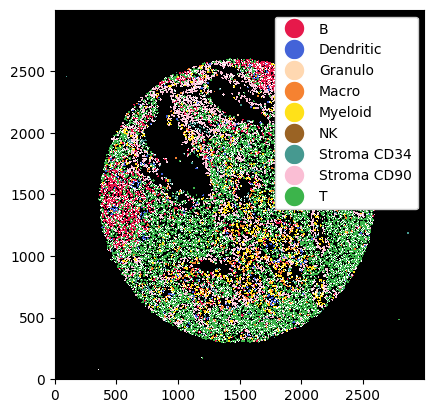

In [23]:
_ = ds_with_binarization_cd4.pl.show(render_image=False, render_segmentation=True, render_labels=True)

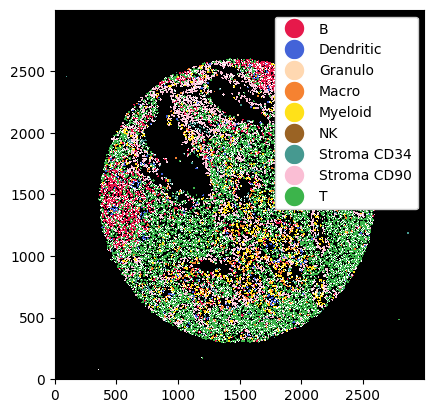

In [25]:
_ = ds_with_binarization_cd4.pl.render_labels().pl.render_segmentation().pl.imshow(legend_label=True)